# Multi-Head Attn

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
sequence_length = 4 # usually maxm sequence length in the batch
batch_size = 1
input_dim = 512 # vector dimension of every word that goes into attention unit
d_model = 512 # output from the model
x = torch.randn((batch_size, sequence_length, input_dim)) # randomly sampled input not creating position encoding right now , it will have dimension = [1, 4, 512]

In [ ]:
x.size()

torch.Size([1, 4, 512])

In [ ]:
# x is something which will be there in multi-headed attention unit
qkv_layer = nn.Linear(input_dim, 3*d_model) # this will give q, k and v vector for all the 8 attention heads (3 * d_model), which will be separated later on, here 3 is multiplied as we have 3 vectors q,k and v.

In [ ]:
qkv = qkv_layer(x)

In [ ]:
qkv.shape

torch.Size([1, 4, 1536])

Here it's 1 batch, 4 words and each word vector is 1536 in size from which I will separte out 8 heads q,k and v.

Text(0.5, 1.0, 'qkv_distribution')

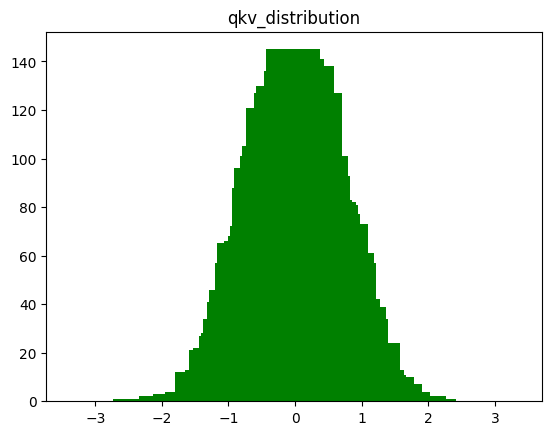

In [ ]:
import matplotlib.pyplot as plt

y_val = torch.histc(qkv, bins=200, min=-3, max=3)
x_val = np.arange(-1, 1, 0.01) * 3

plt.bar(x_val, y_val, align='center', color='green')
plt.title('qkv_distribution')

Values are sampled from random distribution

In [ ]:
# Now coming to multi-headed attention
num_heads = 8
head_dim = d_model//num_heads # 8 attention head so each attention head will have dimension 512/8 = 64
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3*head_dim) # break down the last dimension into product of (number of heads , 3*head_dim) 3 multiplied for q,k and v

In [ ]:
qkv.shape #

torch.Size([1, 4, 8, 192])

In [ ]:
#reshape the qkv by switching it to [batch_size, n_heads, seq_length, 64*3=192]
qkv = qkv.permute(0,2,1,3)

In [ ]:
# now we will take out q, k and v for each head by breaking down it's last dimension
q, k, v = qkv.chunk(3, dim=-1)
q.shape, k.shape, v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

Each q , k and v vectors are for all 8 attention heads.

In [ ]:
# Now we will perform self attention for multiple heads
# For single head it's softmax(q k.T/ sqrt(d_k=64 here) + M=masking)
# newV = attention_score . V
import math
d_k = q.size()[-1] # it will be 64
scaled_attention = torch.matmul(q, k.transpose(-2, -1))/ math.sqrt(d_k)
scaled_attention.shape

torch.Size([1, 8, 4, 4])

So here we got for 8 heads, 4x4 attention matrix
Now why we used transpose and not simple k.T because k is a tensor of multidimension and not simply a matrix

In [ ]:
# masking in encoder we don't require masking but for decoder we require masking
# we will create the mask same as scaled attention shape 1,8,4,4
mask = torch.full(scaled_attention.size(), float('-inf'))
mask = torch.triu(mask, diagonal=1) # take this mask and make triangualr matrix  and leave the value everything above the diagonal as same, diagonal=1 describes how many positions above the diagonal we want to keep the same value.
mask[0][1]

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [ ]:
(scaled_attention + mask)[0][0] # this is for basically 1 head

tensor([[ 0.2742,    -inf,    -inf,    -inf],
        [-0.1151, -0.3439,    -inf,    -inf],
        [-0.4256,  0.6179,  0.1730,    -inf],
        [-0.4276,  0.3121,  0.3044, -0.4874]], grad_fn=<SelectBackward0>)

In [ ]:
scaled_attention += mask # when we apply softmax these negative inf values will become 0

In [ ]:
attention_scores = F.softmax(scaled_attention, dim = -1)

In [ ]:
# using this attention score we will calculate new value
values = torch.matmul(attention_scores, v)
values.shape

torch.Size([1, 8, 4, 64])

Now this value score will have much richer representation of each word

# Function to do the same

In [ ]:
import math
def scaled_dot_attention(q, k, v, mask=None):
  d_k = q.size()[-1]
  scaled_attention = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
  if mask is not None:
    scaled_attention += mask

  attention_scores = F.softmax(scaled_attention, dim = -1)
  values = torch.matmul(attention_scores, v)
  return values, attention_scores

In [ ]:
values, attention = scaled_dot_attention(q, k, v, mask=None)

In [ ]:
attention.shape

torch.Size([1, 8, 4, 4])

In [ ]:
values.shape

torch.Size([1, 8, 4, 64])

In [ ]:
attention[0][0]

tensor([[0.2907, 0.2243, 0.2694, 0.2156],
        [0.2658, 0.2114, 0.1947, 0.3280],
        [0.1430, 0.4061, 0.2603, 0.1906],
        [0.1635, 0.3426, 0.3399, 0.1540]], grad_fn=<SelectBackward0>)

In [ ]:
values, attention = scaled_dot_attention(q, k, v, mask=mask)

In [ ]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.5569, 0.4431, 0.0000, 0.0000],
        [0.1767, 0.5017, 0.3215, 0.0000],
        [0.1635, 0.3426, 0.3399, 0.1540]], grad_fn=<SelectBackward0>)

In [ ]:
values.size()

torch.Size([1, 8, 4, 64])

In [ ]:
# we are going to concatenate all heads together
values = values.reshape(batch_size, sequence_length, num_heads *  head_dim)

In [ ]:
values.shape

torch.Size([1, 4, 512])

In [ ]:
# FFN over multiheaded
linear_layer = nn.Linear(d_model, d_model)

In [ ]:
out = linear_layer(values)

In [ ]:
out.shape

torch.Size([1, 4, 512])

Now this output from linear layer will be much more context aware !!

# Class Implementation

In [ ]:
import torch
import torch.nn as nn
import math

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, d_model, num_heads):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(input_dim , 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):
        batch_size, sequence_length, input_dim = x.size()
        print(f"x.size(): {x.size()}")
        qkv = self.qkv_layer(x)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.permute(0, 2, 1, 3)
        print(f"qkv.size(): {qkv.size()}")
        q, k, v = qkv.chunk(3, dim=-1)
        print(f"q size: {q.size()}, k size: {k.size()}, v size: {v.size()}, ")
        values, attention = scaled_dot_product(q, k, v, mask)
        print(f"values.size(): {values.size()}, attention.size:{ attention.size()} ")
        values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
        print(f"values.size(): {values.size()}")
        out = self.linear_layer(values)
        print(f"out.size(): {out.size()}")
        return out

In [ ]:
input_dim = 1024
d_model = 512
num_heads = 8

batch_size = 30
sequence_length = 5
x = torch.randn( (batch_size, sequence_length, input_dim) )

model = MultiheadAttention(input_dim, d_model, num_heads)
out = model.forward(x)

x.size(): torch.Size([30, 5, 1024])
qkv.size(): torch.Size([30, 5, 1536])
qkv.size(): torch.Size([30, 5, 8, 192])
qkv.size(): torch.Size([30, 8, 5, 192])
q size: torch.Size([30, 8, 5, 64]), k size: torch.Size([30, 8, 5, 64]), v size: torch.Size([30, 8, 5, 64]), 
values.size(): torch.Size([30, 8, 5, 64]), attention.size:torch.Size([30, 8, 5, 5]) 
values.size(): torch.Size([30, 5, 512])
out.size(): torch.Size([30, 5, 512])
